# Tutorial 7. Deep Neural Networks

In this notebook we will cover the following:

1. [Building a perceptron](#perceptron)
2. [Building a single layer neural network](#single)
3. [Building a deep neural network](#deep)
4. [Creating a vector quantizer](#quantizer)
5. [Building a recurrent neural network for sequential data analysis](#recurrent)
6. [Visualizing the characters in an optical character recognition database](#characters)
7. [Building an optical character recognizer using neural networks](#optical)

The human brain's job is to identify and recognize things, and we want machines to be able to do the same. A **neural network** is a framework that is modeled after the human brain to simulate our learning processes. Neural networks are designed to learn from data and recognize underlying patterns.

Neural networks can be used classification, clustering, generation and other related tasks. A neural network consists of layers of **neurons** that are modeled after the bilogical neurons in the brain. Each layer is a set of independent neurons that are connected to the neurons of the adjacent layers. The input layer corresponds to the input data that we provide and the output layer consists of the ouput that we desire. All the layers inbetween are called **hidden layers**, the larger number of hidden layers the more freedom to train itself and higher accuracy. 

If we wanted neural network to clasify data, in order for a neural network to work, we need to provide labeled training data. The neural network will train itself by optimizing the cost function. The cost function is the error between actual labels and the predicted labels from the neural network. We keep iterating until the error goes below a pre-defined threshold. 

**Deep** neural networks are neural networks that consist of many hidden layers, and falls under the realm of deep learning - the field dedicated to the stufy of neural networks.

We will use the **neurolab** package for python available here: https://pythonhosted.org/neurolab/install.html.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import neurolab

## 7.1 Building a perceptron <a class="anchor" id="perceptron"></a>

A **perceptron** is a single neuron that performs all the computation. It is a very simple model, but it forms the basis of building a complex neural network. The neuron combines inputs using different weights, and it then adds a bias value to compute the output. It's a simple linear equation relating input values with the ouput of the perceptron.

![title](img/perceptron.png)

In this example we will work with generated test data.

In [2]:
data = pd.DataFrame([[0.3,0.3],[0.1,0.4],[0.4,0.6],[0.9,0.5]],columns=['x1','x2'])
data['y'] = np.array([[0],[0],[0],[1]])
data.head()

,x1,x2,y
0,0.3,0.3,0
1,0.1,0.4,0
2,0.4,0.6,0
3,0.9,0.5,1


Make a plot:

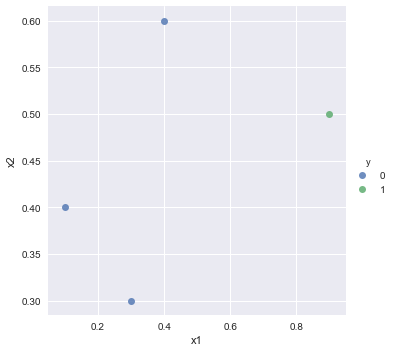

In [3]:
sns.lmplot(data=data,x='x1',y='x2',hue='y',fit_reg=False)

### Build perceptron

Build a perceptron with two inputs, the function also needs the mimimum and maximum values of the input data:

In [4]:
perceptron = neurolab.net.newp([[0,1],[0,1]],1) # 1 perceptron with max/min for inputs

Train the perceptron, the number of *epochs* specifies the number of complete passes through the training set. The *show* parameter specifies how frequently we want to display the progress. The *lr* parameter specifies the learning rate of the perceptron, it is the step size for the algorithm to search through the parameter space. If learning rate is large then the algorithm will move faster, but might miss the optimum value.

In [5]:
X = data.drop(['y'],axis=1);y=data.y
error = perceptron.train(X.values,y.values.reshape((X.shape[0],1)),epochs=50,show=15,lr=0.01)

The goal of learning is reached


Note above we had to reshape the y values to a 2dimensional axis for the function to work. Now let's plot the results:

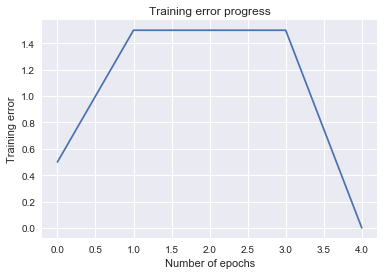

In [6]:
plt.figure()
plt.plot(error);plt.xlabel('Number of epochs');plt.ylabel('Training error');plt.title('Training error progress')

Can see the the error drops to zero after 4 epochs.

## 7.2 Building a single layer neural network <a class="anchor" id="single"></a>

Now that we know how to create aperceptron, we can create a single layer neural network, which consists of multiple neurons in a single layer. We have an input, a hidden layer, and an output layer.

For this example we will use the included file *data_single_layer.txt*:

In [7]:
data = pd.read_csv('data_single_layer.txt',delim_whitespace=True,names=['x1','x2','y1','y2'])
data.head()

,x1,x2,y1,y2
0,1.0,4.0,0,0
1,1.1,3.9,0,0
2,1.2,4.1,0,0
3,0.9,3.7,0,0
4,7.0,4.0,0,1


Make a plot:

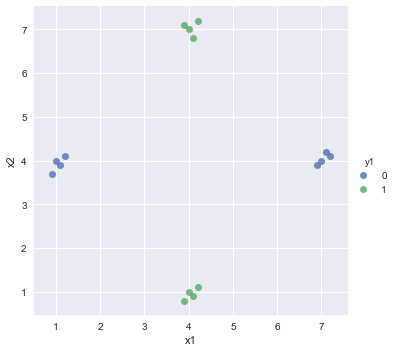

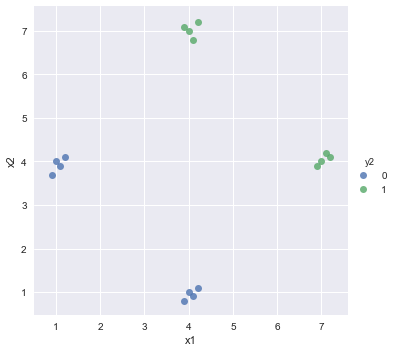

In [8]:
sns.lmplot(data=data,x='x1',y='x2',hue='y1',fit_reg=False)
sns.lmplot(data=data,x='x1',y='x2',hue='y2',fit_reg=False)

Extract the minimum and maximum values:

In [9]:
maxs=data[['x1','x2']].max()
mins=data[['x1','x2']].min()

Define a single layer neural network with two neurons in the hidden layer:

In [10]:
# Each element in the list specifies the min/max values of the inputs
single_layer_net = neurolab.net.newp([[mins.x1,maxs.x1],[mins.x2,maxs.x2]],2)
# Train the nerual network until 50 epochs
X=data.drop(['y1','y2'],axis=1);y=data[['y1','y2']]
error = single_layer_net.train(X.values,y.values,epochs=50,show=20,lr=0.01)

Epoch: 20; Error: 4.0;
Epoch: 40; Error: 4.0;
The maximum number of train epochs is reached


Plot the errror:

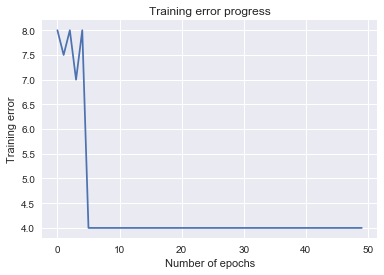

In [11]:
plt.figure()
plt.plot(error);plt.xlabel('Number of epochs');plt.ylabel('Training error');plt.title('Training error progress')

Can see from the above the error converges to 4 and doesn't reach 0. Now let's test the neural network on new test data.

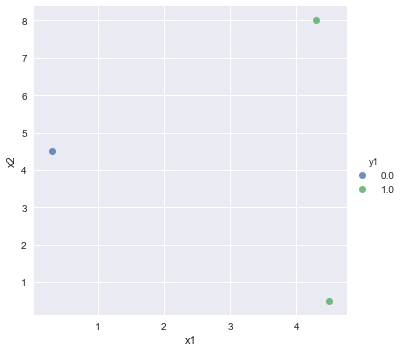

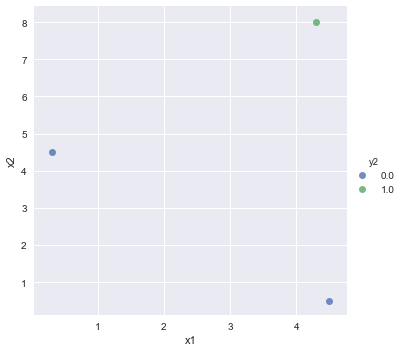

In [12]:
# Test data
test = pd.DataFrame([[0.3,4.5],[4.5,0.5],[4.3,8]],columns=['x1','x2'])
pred = single_layer_net.sim(test.values)

# Make plots
test['y1'] = pred[:,0];test['y2']=pred[:,1]
sns.lmplot(data=test,x='x1',y='x2',hue='y1',fit_reg=False)
sns.lmplot(data=test,x='x1',y='x2',hue='y2',fit_reg=False)

Can compare the above to the training dataset we used, to see how it does for points in close to the same area.

## 7.3 Building a deep neural network <a class="anchor" id="deep"></a>

A deep neural network consists of an input layer, many hidden layers, and an output layer. Looks like this multilayer neural network:

![title](img/deep.png)

We will generate some training data base on a function to transform the values, and we expect the neural network to learn the function on its own with only input and output training data:

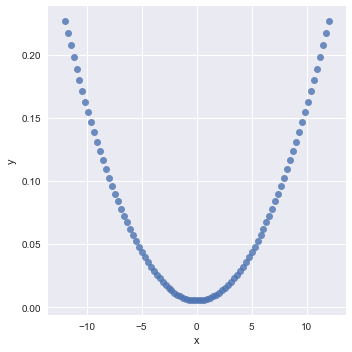

In [13]:
min_value=-12
max_value=12
num_datapoints=90

x = np.linspace(min_value,max_value,num_datapoints)
y = 2*np.square(x) + 7
y /= np.linalg.norm(y)
#Reshape the arrays
data = pd.DataFrame({'x':x,'y':y})
sns.lmplot(data=data,x='x',y='y',fit_reg=False)

Build deep neural network with each hidden layer having 10 neurons:

In [14]:
#Each hidden layer has 10 neurons and the output layer has 1 neuron
multilayer_net = neurolab.net.newff([[min_value,max_value]],[10,10,1])

The training algorithm is set to gradient descent that is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. The learningRate variable controls how large of a step we take downhill during each iteration. If we take too large of a step, we may step over the minimum. 

In [15]:
multilayer_net.trainf = neurolab.train.train_gd
# Train
error = multilayer_net.train(data.x.values.reshape((num_datapoints,1)),
                             data.y.values.reshape((num_datapoints,1)),
                            epochs=800,show=100,goal=0.01)

Epoch: 100; Error: 2.086941630742826;
Epoch: 200; Error: 0.3982914619781928;
Epoch: 300; Error: 0.14410094393172654;
Epoch: 400; Error: 0.07877849255397519;
Epoch: 500; Error: 0.1947789911652117;
Epoch: 600; Error: 0.08156999653613474;
Epoch: 700; Error: 0.06708037471416688;
Epoch: 800; Error: 0.0749822256009174;
The maximum number of train epochs is reached


Plot the training error:

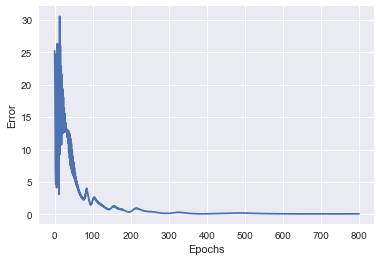

In [16]:
plt.plot(error);plt.xlabel('Epochs');plt.ylabel('Error')

Let's make a set of predictions on new data and see what it looks like:

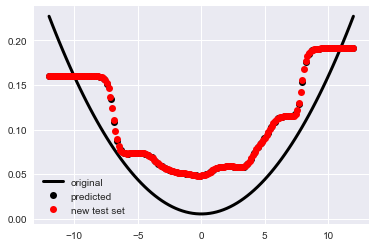

In [17]:
#Run network on training data to see performance
predicted_output= multilayer_net.sim(data.x.values.reshape((num_datapoints,1)))
x2=np.linspace(min_value,max_value,num_datapoints*2)
y2 = multilayer_net.sim(x2.reshape((num_datapoints*2,1)))
#Plot
plt.figure()
plt.plot(x,y,'k',lw=3.0,label='original')
plt.plot(x,predicted_output,'ko',label='predicted')
plt.plot(x2,y2,'ro',label='new test set')
plt.legend()

Can see it almost gets the correct shape. Can play around with the number of neurons and see if it changes.

## 7.4 Creating a vector quantizer <a class="anchor" id="quantizer"></a>

As we learned in Tutorial 4, **vector quantization** is the *N* dimensional version of "rounding off". 

In this example we will use included data file *data_vq.txt*:

In [18]:
data= pd.read_csv('data_vq.txt',delim_whitespace=True,names=['x1','x2','y1','y2','y3','y4'])
data.head()


,x1,x2,y1,y2,y3,y4
0,1.0,4.0,1,0,0,0
1,1.1,3.9,1,0,0,0
2,1.2,4.1,1,0,0,0
3,0.9,3.7,1,0,0,0
4,7.0,4.0,0,1,0,0


We see above there are 4 labels. We will define a **learning vector quantization (LVQ)** neural network with two layers. The array in the last parameter specifies the percentage weightage to each ouput (should sum up to 1):

In [19]:
#Define neural network with 2 layers, 10 neurons in input layer 
# and 4 neurons in output layer
X = data[['x1','x2']]; y = data[['y1','y2','y3','y4']]
net = neurolab.net.newlvq(neurolab.tool.minmax(X.values),10,[0.25,0.25,0.25,0.25])

# Train the LVQ neural network
error = net.train(X.values,y.values,epochs=100,goal=-1)

/Users/Justin/anaconda3/lib/python3.6/site-packages/neurolab/net.py:179: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  layer_out.np['w'][n][st:i].fill(1.0)


Epoch: 100; Error: 0.0;
The maximum number of train epochs is reached


Create a grid of values for testing and visualization:

In [20]:
# Input grid
xx,yy = np.meshgrid(np.arange(0,8,0.2),np.arange(0,8,0.2))
xx.shape= xx.size, 1
yy.shape= yy.size, 1
input_grid = np.concatenate((xx,yy),axis=1)

In [21]:
# Evaluate the network on this grid
output_grid = net.sim(input_grid)

# Define the 4 classes in data
class1 = X.loc[(y.y1==1)]
class2 = X.loc[(y.y2==1)]
class3 = X.loc[(y.y3==1)]
class4 = X.loc[(y.y4==1)]

# Define the grid for all the classes
grid1 = input_grid[output_grid[:,0]==1 ]
grid2 = input_grid[output_grid[:,1]==1 ]
grid3 = input_grid[output_grid[:,2]==1 ]
grid4 = input_grid[output_grid[:,3]==1 ]

Plot the outputs:

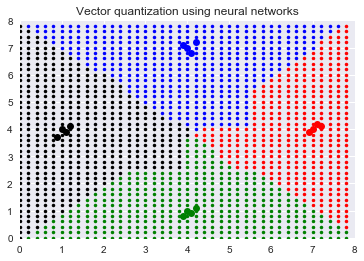

In [22]:
plt.plot(class1.x1,class1.x2,'ko')
plt.plot(class2.x1,class2.x2,'ro')
plt.plot(class3.x1,class3.x2,'go')
plt.plot(class4.x1,class4.x2,'bo')
plt.plot(grid1[:,0],grid1[:,1],'k.')
plt.plot(grid2[:,0],grid2[:,1],'r.')
plt.plot(grid3[:,0],grid3[:,1],'g.')
plt.plot(grid4[:,0],grid4[:,1],'b.')
plt.axis([0,8,0,8])
plt.title('Vector quantization using neural networks')

Space is divided into regions, each region corresponds to a bucket in the list of vector-quantized regions in the space.

## 7.5 Building a recurrent neural network for sequential data analysis <a class="anchor" id="recurrent"></a>

Recurrent neural networks are important for analyzing sequential and time-series data. When dealing with seuqential and time series data, we need to account for the temporal dependencies in the data. 

In this example we will generate waveform data:

In [23]:
# Create samples for training and testing
def create_waveform(num_points):
    wave = pd.DataFrame( np.tile(np.cos(np.arange(0,num_points)),(4,1)).T,columns=['x1','x2','x3','x4'])
    wave.x2 = wave.x2*2
    wave.x3 = wave.x3*3
    wave.x4 = wave.x4*4
    
    amps    = pd.DataFrame({'amp1':np.ones(num_points),'amp2':4+np.zeros(num_points),'amp3':2*np.ones(num_points),
                        'amp4':0.5+np.zeros(num_points)})
    
    #Concatenate waves and amplitudes together 
    data = pd.concat([wave.x1,wave.x2,wave.x3,wave.x4], axis=0, ignore_index=True)
    amp  = pd.concat([amps.amp1,amps.amp2,amps.amp3,amps.amp4], axis=0, ignore_index=True)
    
    return data,amp

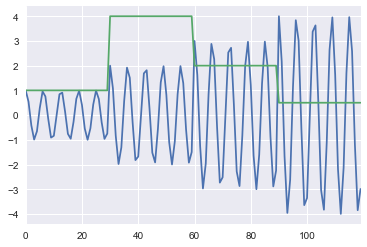

In [24]:
# Create sample data with 30 points and make plots
num_points=30
data,amplitude = create_waveform(num_points)
data.plot()
amplitude.plot()

Creat a recurrent neural network with 2 layers, and set the intialized functions for each layer, then train the recurrent neural network:

In [25]:
# Network with 2 layers
net = neurolab.net.newelm([[-2,2]],[10,1],[neurolab.trans.TanSig(),neurolab.trans.PureLin()])
# Set initialized functions for each layer
net.layers[0].initf = neurolab.init.InitRand([-0.1,0.1],'wb')
net.layers[1].initf = neurolab.init.InitRand([-0.1,0.1],'wb')
net.init()

Epoch: 100; Error: 1.5160529275851122;
Epoch: 200; Error: 0.6271211462161403;
Epoch: 300; Error: 0.2684376664779806;
Epoch: 400; Error: 0.29483470671176043;
Epoch: 500; Error: 0.35864318698374487;
Epoch: 600; Error: 0.22554689347375792;
Epoch: 700; Error: 0.19163413653656244;
Epoch: 800; Error: 0.17112898710231625;
Epoch: 900; Error: 0.16113965838770475;
Epoch: 1000; Error: 0.1549178052417129;
The maximum number of train epochs is reached


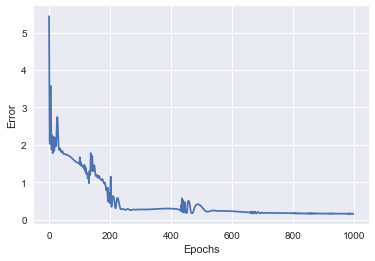

In [26]:
#Training the recurrent neural network
shape = data.values.shape[0]
error = net.train(data.values.reshape(shape,1),amplitude.values.reshape(shape,1),
                  epochs=1000,show=100,goal=0.01)
plt.plot(error);plt.xlabel('Epochs');plt.ylabel('Error')

Get the predicted output from the neural network and plot the results:

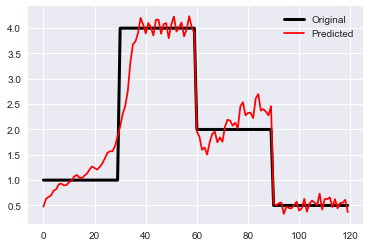

In [27]:
predicted = net.sim(data.values.reshape(shape,1))
plt.figure()
plt.plot(amplitude,'k',lw=3.0,label='Original')
plt.plot(predicted,'r',label='Predicted');plt.legend()

Can see from the above it does a reasonable job at predicting the amplitude given the waveform. Define a function that can draw the ouput after passing dat through the trained neural network:

In [28]:
def draw_output(net,num_points_test):
    data_test,amplitude_test = create_waveform(num_points_test)
    pred_test = net.sim(data_test.values.reshape(num_points_test*4,1))
    plt.figure();plt.title('Num_points = {}'.format(num_points_test))
    plt.plot(amplitude_test.values,'k',lw=3.0,label='Original')
    plt.plot(pred_test,'r',label='Predicted');plt.legend()

Now can create waveforms of random length and see if neural network can predict the amplitude:

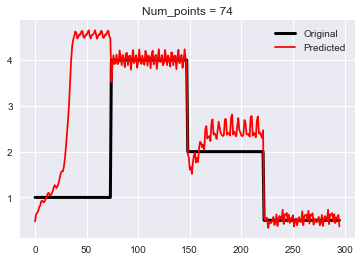

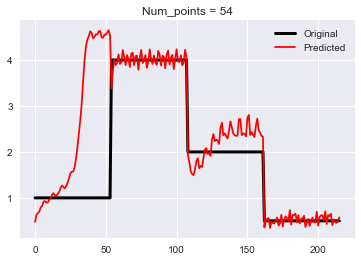

In [29]:
draw_output(net,74)
draw_output(net,54)

Can see again that it does a reasonable job for different waveform lengths.

## 7.6 Building an optical character recognizer using neural networks <a class="anchor" id="optical"></a>

Neural networks can be used for optical character recognition, the process of identifying handwritten characters in images.

We will use the data file, *letter.data*, included, and also available for download here: http://ai.stanford.edu/~btaskar/ocr/

1. id: each letter is assigned a unique integer id
2. letter: a-z
3. next_id: id for next letter in the word, -1 if last letter
4. word_id: each word is assigned a unique integer id (not used)
5. position: position of letter in the word (not used)
6. fold: 0-9 -- cross-validation fold
7. p_i_j: 0/1 -- value of pixel in row i, column j

In [30]:
letterdf = pd.read_table('letter.data',header=None)

In [31]:
letterdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,125,126,127,128,129,130,131,132,133,134
0,1,o,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
1,2,m,3,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
2,3,m,4,1,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
3,4,a,5,1,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,n,6,1,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
5,6,d,7,1,6,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,NaN
6,7,i,8,1,7,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,NaN
7,8,n,9,1,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
8,9,g,-1,1,9,0,0,1,1,1,...,0,0,0,0,0,0,1,0,0,NaN
9,10,o,11,2,1,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


We will only take 20 datapoints from the input file, if you look at the first 20 letters below, you will see there are 7 distinct letters among them 'omandig':

In [32]:
letters20 = letterdf.iloc[:20,:]
# Unique letters 
unique = letters20.ix[:,1].unique()
print('Unique letters in first 20: ',unique)

Unique letters in first 20:  ['o' 'm' 'a' 'n' 'd' 'i' 'g']


We now want to create a vector for data that has the letters above, and the datapoints will have a 1 in the corresponding element:

In [33]:
lettersencode = pd.get_dummies(letters20.ix[:,1])
lettersencode.head(10)

,a,d,g,i,m,n,o
0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0
5,0,1,0,0,0,0,0
6,0,0,0,1,0,0,0
7,0,0,0,0,0,1,0
8,0,0,1,0,0,0,0
9,0,0,0,0,0,0,1


We see from the above that each letter has been vectorized and is represented by a '1' in the column.

Now we want to extract the character vector:

In [34]:
startind=6;endind = -1
characters = letters20.iloc[:,startind:endind]
characters.head()

,6,7,8,9,10,11,12,13,14,15,...,124,125,126,127,128,129,130,131,132,133
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have a 128 column data that goes along with the encoded letters, and then we will want to split into training and testing dataset. We will use 90% of data for training and 10% for testing:

In [35]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(characters,lettersencode,test_size=0.1,random_state=4)

#### Train neural network with 10,000 epochs
Then plot the error:

Epoch: 1000; Error: 0.21581750946167724;
Epoch: 2000; Error: 0.1332406685694399;
Epoch: 3000; Error: 0.08868205158909369;
Epoch: 4000; Error: 0.06256580816398742;
Epoch: 5000; Error: 0.06323175485763506;
Epoch: 6000; Error: 0.04952539984585368;
Epoch: 7000; Error: 0.05593942269779839;
Epoch: 8000; Error: 0.027134577139445528;
Epoch: 9000; Error: 0.0292231521547478;
Epoch: 10000; Error: 0.02586520736900532;
The maximum number of train epochs is reached


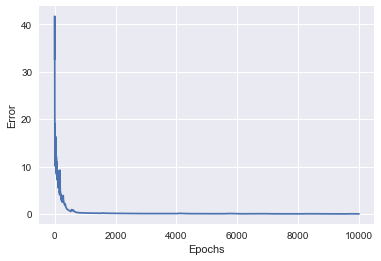

In [36]:
net = neurolab.net.newff([[0,1] for _ in range(128)],[128,16,len(unique)])
net.trainf = neurolab.train.train_gd #gradient descent
error = net.train(Xtrain.values,ytrain.values,epochs=10000, show=1000,goal=0.01)
plt.plot(error);plt.xlabel('Epochs');plt.ylabel('Error')

Can see the error gets rapidly close to zero for the training data.

Now let's predict the ouput for the test inputs, the return values are not 1's and 0's but float numbers so we will take the largest value as the 1 in the encoded vector:

In [37]:
predicted = net.sim(Xtest.values)
letters = lettersencode.columns.values
#Print predicted vs true value
print('Predicted vs True for test data')
for n in range(len(Xtest.index)):
    pred_encoded = np.argmax( predicted[n,:] )
    orig_ind = ytest.iloc[n,:] == 1
    orig_letter = letters[orig_ind.values][0]
    pred_letter = letters[pred_encoded]
    print('Orignal letter: ',orig_letter, ', Predicted letter: ',pred_letter)

Predicted vs True for test data
Orignal letter:  m , Predicted letter:  m
Orignal letter:  a , Predicted letter:  n


Can see for our limited sample that the neural network correctly predicted the characters.